In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
df = pd.read_csv('2019-05-19.csv', sep=' ')
df.head()

,No,Profile,Tanggal,Jam,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU,Status,Unnamed: 22
0,1,BANDUNG,2019-05-19,00:04:19,21.35,0.78,6.77,14.06,26.168,409.86,251.202,0.0,0.0,0.0,2.77,0.0,21.4,100.0,0.600,5,9,BAIK,NaN
1,2,BANDUNG,2019-05-19,00:15:01,5.93,0.82,14.87,17.23,53.853,394.79,501.356,0.0,0.0,0.0,11.95,0.0,42.6,200.0,0.000,2,12,BAIK,NaN
2,3,BANDUNG,2019-05-19,00:30:06,6.62,0.63,22.24,2.31,38.304,390.66,753.291,0.0,0.0,0.0,12.71,0.0,63.6,299.2,0.000,2,13,BAIK,NaN
3,4,BANDUNG,2019-05-19,00:49:19,13.29,0.44,19.00,5.32,18.962,401.23,251.043,0.0,0.0,0.0,1.20,0.0,21.3,88.2,0.525,5,6,BAIK,NaN
4,5,BANDUNG,2019-05-19,01:04:19,2.44,0.47,26.74,13.61,35.270,381.67,250.471,0.0,0.0,0.0,3.52,0.0,21.3,97.4,0.975,5,9,BAIK,NaN


In [4]:
# convert TIME to datetime format:

def combine_date(df, tab_name):
    list_tab = []
    for i in range(df.shape[0]):
        list_tab.append(df.loc[i, 'Tanggal'] + 'T' + df.loc[i, tab_name][0:2])
    return np.array(list_tab, dtype='datetime64')

In [5]:
# convert TIME to datetime format:

df['Datetime'] = combine_date(df, 'Jam')

In [6]:
# convert into hourly data

df = df[['Datetime','O3','CO','NO2','SO2','NO','CO2','VOC','PM1','PM2.5','PM4','PM10','TSP','TEMP','HUM','WS','WD','ISPU']]
df2 = df.groupby(['Datetime']).mean()
df2.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 00:00:00,11.797500,0.667500,15.720,9.7300,34.32175,399.135000,439.22300,0.0,0.0,0.0,7.157500,0.0,37.225000,171.850000,0.28125,3.500000,10.000000
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.0900,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,26.3100,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,16.250000
2019-05-19 03:00:00,4.740000,0.180000,25.975,24.3900,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,19.692500,0.202500,20.395,18.6225,53.37925,399.335000,694.23975,0.0,0.0,0.0,5.262500,0.0,53.475000,272.500000,0.18750,5.250000,13.250000


In [7]:
# descriptive statistics

df2.describe()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
count,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000,1737.000000
mean,8.538909,0.233172,16.681910,12.013894,37.086256,394.616480,260.053778,0.309564,0.383692,0.451982,6.157770,0.562012,25.266942,77.634191,24.291226,7.129031,10.097848
std,3.997292,0.388102,5.373487,4.411251,12.521778,4.180224,60.773321,2.286104,2.874126,3.378291,4.149511,4.184787,6.707977,29.743129,51.993683,3.523245,5.049788
min,0.270000,0.010000,2.040000,2.162500,3.128750,380.420000,187.518000,0.000000,0.000000,0.000000,0.885000,0.000000,11.250000,26.866667,0.000000,0.000000,4.250000
25%,5.881667,0.083333,13.010000,9.015000,28.443500,391.830000,247.798333,0.000000,0.000000,0.000000,4.340000,0.000000,21.266667,57.850000,0.237500,4.666667,8.166667
50%,7.813333,0.160000,15.916667,11.730000,39.252250,394.602000,250.926250,0.000000,0.000000,0.000000,5.571667,0.000000,24.100000,77.083333,1.312500,5.833333,9.500000
75%,10.373333,0.296667,19.935000,14.595000,46.015500,397.415000,253.286667,0.000000,0.000000,0.000000,7.090000,0.000000,28.400000,94.066667,5.075000,10.500000,11.000000
max,33.741667,13.950000,99.600000,46.290000,194.554000,408.820000,1240.713500,51.600000,68.700000,79.800000,91.600000,92.900000,124.600000,313.400000,199.200000,15.000000,156.500000


In [8]:
# calculate quantile from each attributes
def calculate_quantile (i, df2):
    Q1 = df2[[i]].quantile(0.25)[0]
    Q3 = df2[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = df2[[i]].min()[0]
    max = df2[[i]].max()[0]
    min_IQR = Q1 - 1.5*IQR
    max_IQR = Q3 + 1.5*IQR
    
    return Q1, Q3, min, max, min_IQR, max_IQR

# delete first and last rows to avoid missing value extrapolation
df2.drop(index=[df2.index[0], df2.index[df2.shape[0]-1]], inplace=True)

# find and interpolate the outliers
for i in df2.columns:
    print('\nAttribute-',i,':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculate_quantile(i, df2)
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    print('min IQR = %.2f' % min_IQR)
    print('max IQR = %.2f' % max_IQR)
    if (min < min_IQR):
        print('---> Low outlier is found = %.2f' % min)
    if (max > max_IQR):
        print('---> High outlier is found = %.2f' % max)
    
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x

    def convert_nan_HUM (x, max_IQR=100.0, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x
    
    if (i == 'HUM'):
        df2[i] = df2[i].map(convert_nan_HUM)
        df2[i] = df2[i].interpolate(method='linear')
    if (i != 'HUM'):
        df2[i] = df2[i].map(convert_nan)
        df2[i] = df2[i].interpolate(method='linear')
    
    if (len(df2[df2[i].isnull()][i]) == 0):
        print('################  Outliers have been interpolated  ################')


Attribute- O3 :
Q1 = 5.88
Q3 = 10.37
min IQR = -0.85
max IQR = 17.10
---> High outlier is found = 33.74
################  Outliers have been interpolated  ################

Attribute- CO :
Q1 = 0.08
Q3 = 0.30
min IQR = -0.24
max IQR = 0.62
---> High outlier is found = 13.95
################  Outliers have been interpolated  ################

Attribute- NO2 :
Q1 = 13.01
Q3 = 19.94
min IQR = 2.62
max IQR = 30.32
---> Low outlier is found = 2.04
---> High outlier is found = 99.60
################  Outliers have been interpolated  ################

Attribute- SO2 :
Q1 = 9.00
Q3 = 14.61
min IQR = 0.60
max IQR = 23.01
---> High outlier is found = 46.29
################  Outliers have been interpolated  ################

Attribute- NO :
Q1 = 28.44
Q3 = 46.02
min IQR = 2.09
max IQR = 72.37
---> High outlier is found = 194.55
################  Outliers have been interpolated  ################

Attribute- CO2 :
Q1 = 391.83
Q3 = 397.41
min IQR = 383.47
max IQR = 405.77
---> Low outlier is found 

In [9]:
# view the table within first 5 rows after outliers interpolation

df2.head()

,O3,CO,NO2,SO2,NO,CO2,VOC,PM1,PM2.5,PM4,PM10,TSP,TEMP,HUM,WS,WD,ISPU
Datetime,,,,,,,,,,,,,,,,,
2019-05-19 01:00:00,3.816667,0.373333,22.600,20.090000,39.82100,388.536667,250.39400,0.0,0.0,0.0,3.293333,0.0,20.966667,95.033333,0.67500,4.666667,12.666667
2019-05-19 02:00:00,6.450000,0.332500,24.130,19.600833,51.29325,396.242500,251.04575,0.0,0.0,0.0,6.487500,0.0,20.150000,97.500000,0.09375,3.750000,13.833333
2019-05-19 03:00:00,4.740000,0.180000,25.975,19.111667,43.51850,401.355000,252.24875,0.0,0.0,0.0,4.700000,0.0,19.850000,100.000000,0.07500,5.000000,15.000000
2019-05-19 04:00:00,7.030833,0.202500,20.395,18.622500,53.37925,399.335000,252.22100,0.0,0.0,0.0,5.262500,0.0,18.950000,100.000000,0.18750,5.250000,13.250000
2019-05-19 05:00:00,9.321667,0.297500,27.545,18.227500,52.43100,393.270000,252.19325,0.0,0.0,0.0,6.510000,0.0,18.050000,100.000000,0.24375,5.000000,12.625000


In [10]:


dataset = np.log1p(df2[['TEMP']].values)
dataset.shape

(1735, 1)

<Figure size 864x360 with 0 Axes>

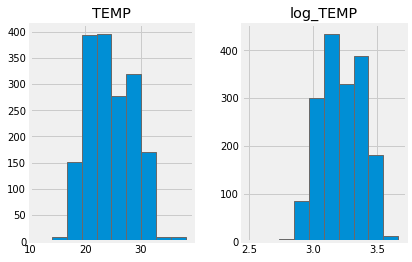

In [11]:

dist_df = pd.DataFrame({'TEMP' : df2['TEMP'].values, 'log_TEMP' : dataset[:,0]})


plt.figure(figsize=(12,5))
dist_df.hist();

In [12]:


train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1301 434


In [13]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [14]:

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (1299, 1)
Shape of trainY : (1299,)
Shape of testX : (432, 1)
Shape of testY : (432,)


In [15]:


trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (1299, 1, 1)
Shape of testX : (432, 1, 1)


In [16]:


model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=32, verbose=2)

Epoch 1/500
 - 1s - loss: 9.4845
Epoch 2/500
 - 0s - loss: 8.7604
Epoch 3/500
 - 0s - loss: 8.0822
Epoch 4/500
 - 0s - loss: 7.4346
Epoch 5/500
 - 0s - loss: 6.8146
Epoch 6/500
 - 0s - loss: 6.2252
Epoch 7/500
 - 0s - loss: 5.6682
Epoch 8/500
 - 0s - loss: 5.1406
Epoch 9/500
 - 0s - loss: 4.6317
Epoch 10/500
 - 0s - loss: 4.1197
Epoch 11/500
 - 0s - loss: 3.5781
Epoch 12/500
 - 0s - loss: 3.0006
Epoch 13/500
 - 0s - loss: 2.4149
Epoch 14/500
 - 0s - loss: 1.8658
Epoch 15/500
 - 0s - loss: 1.3875
Epoch 16/500
 - 0s - loss: 0.9974
Epoch 17/500
 - 0s - loss: 0.6944
Epoch 18/500
 - 0s - loss: 0.4670
Epoch 19/500
 - 0s - loss: 0.3011
Epoch 20/500
 - 0s - loss: 0.1841
Epoch 21/500
 - 0s - loss: 0.1066
Epoch 22/500
 - 0s - loss: 0.0604
Epoch 23/500
 - 0s - loss: 0.0363
Epoch 24/500
 - 0s - loss: 0.0254
Epoch 25/500
 - 0s - loss: 0.0211
Epoch 26/500
 - 0s - loss: 0.0196
Epoch 27/500
 - 0s - loss: 0.0192
Epoch 28/500
 - 0s - loss: 0.0190
Epoch 29/500
 - 0s - loss: 0.0190
Epoch 30/500
 - 0s - lo

 - 0s - loss: 0.0089
Epoch 239/500
 - 0s - loss: 0.0088
Epoch 240/500
 - 0s - loss: 0.0088
Epoch 241/500
 - 0s - loss: 0.0089
Epoch 242/500
 - 0s - loss: 0.0088
Epoch 243/500
 - 0s - loss: 0.0088
Epoch 244/500
 - 0s - loss: 0.0088
Epoch 245/500
 - 0s - loss: 0.0088
Epoch 246/500
 - 0s - loss: 0.0089
Epoch 247/500
 - 0s - loss: 0.0089
Epoch 248/500
 - 0s - loss: 0.0088
Epoch 249/500
 - 0s - loss: 0.0088
Epoch 250/500
 - 0s - loss: 0.0089
Epoch 251/500
 - 0s - loss: 0.0090
Epoch 252/500
 - 0s - loss: 0.0088
Epoch 253/500
 - 0s - loss: 0.0088
Epoch 254/500
 - 0s - loss: 0.0089
Epoch 255/500
 - 0s - loss: 0.0088
Epoch 256/500
 - 0s - loss: 0.0088
Epoch 257/500
 - 0s - loss: 0.0088
Epoch 258/500
 - 0s - loss: 0.0089
Epoch 259/500
 - 0s - loss: 0.0088
Epoch 260/500
 - 0s - loss: 0.0088
Epoch 261/500
 - 0s - loss: 0.0088
Epoch 262/500
 - 0s - loss: 0.0088
Epoch 263/500
 - 0s - loss: 0.0088
Epoch 264/500
 - 0s - loss: 0.0088
Epoch 265/500
 - 0s - loss: 0.0088
Epoch 266/500
 - 0s - loss: 0.0089

Epoch 473/500
 - 0s - loss: 0.0090
Epoch 474/500
 - 0s - loss: 0.0088
Epoch 475/500
 - 0s - loss: 0.0088
Epoch 476/500
 - 0s - loss: 0.0088
Epoch 477/500
 - 0s - loss: 0.0088
Epoch 478/500
 - 0s - loss: 0.0088
Epoch 479/500
 - 0s - loss: 0.0088
Epoch 480/500
 - 0s - loss: 0.0088
Epoch 481/500
 - 0s - loss: 0.0088
Epoch 482/500
 - 0s - loss: 0.0087
Epoch 483/500
 - 0s - loss: 0.0087
Epoch 484/500
 - 0s - loss: 0.0088
Epoch 485/500
 - 0s - loss: 0.0088
Epoch 486/500
 - 0s - loss: 0.0088
Epoch 487/500
 - 0s - loss: 0.0089
Epoch 488/500
 - 0s - loss: 0.0088
Epoch 489/500
 - 0s - loss: 0.0088
Epoch 490/500
 - 0s - loss: 0.0088
Epoch 491/500
 - 0s - loss: 0.0088
Epoch 492/500
 - 0s - loss: 0.0088
Epoch 493/500
 - 0s - loss: 0.0088
Epoch 494/500
 - 0s - loss: 0.0088
Epoch 495/500
 - 0s - loss: 0.0088
Epoch 496/500
 - 0s - loss: 0.0089
Epoch 497/500
 - 0s - loss: 0.0088
Epoch 498/500
 - 0s - loss: 0.0088
Epoch 499/500
 - 0s - loss: 0.0088
Epoch 500/500
 - 0s - loss: 0.0089


In [17]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)


trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.39 RMSE
Test Score: 3.19 RMSE


In [18]:
test_series = pd.Series(testY)


if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
3.19 < 4.40


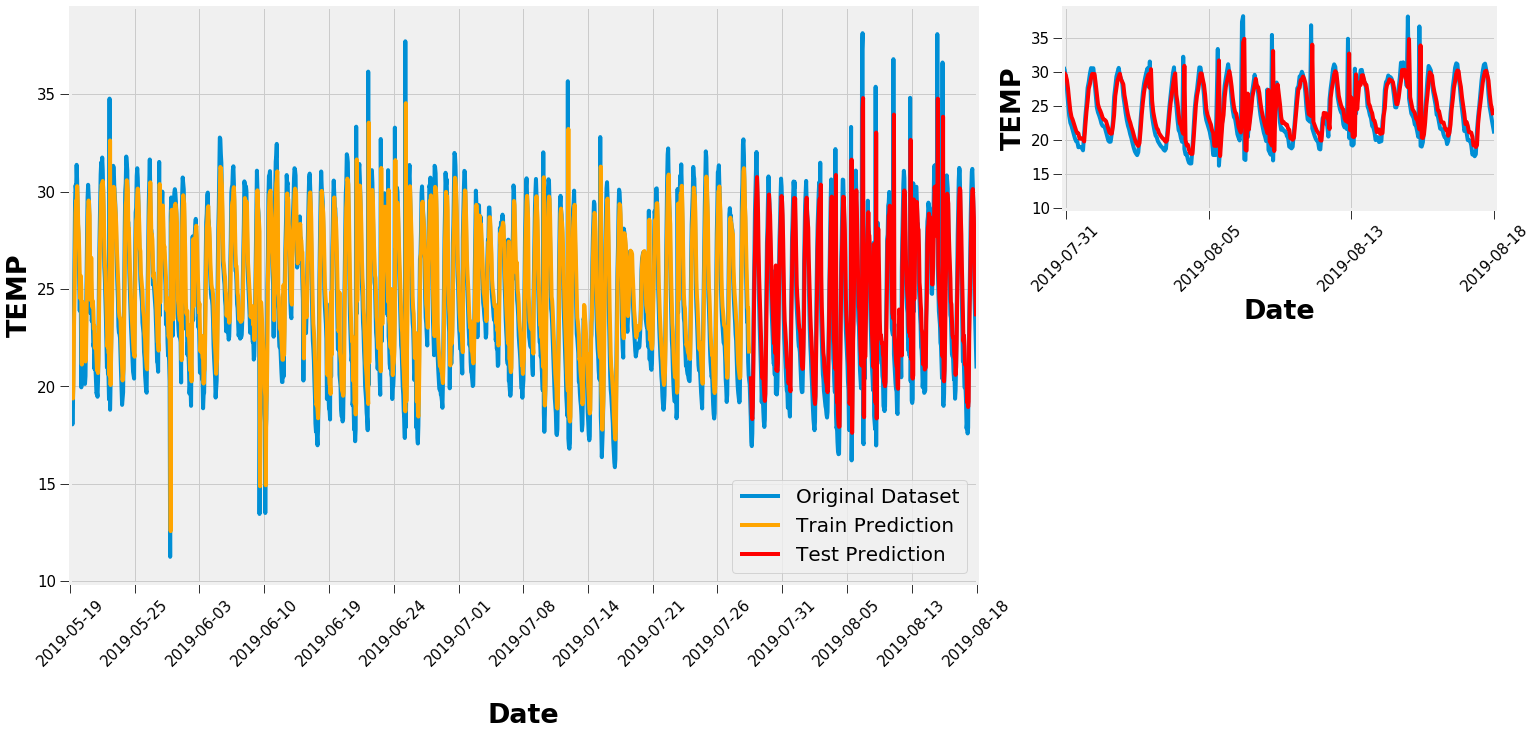

In [19]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df2.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

In [20]:


dataset = np.log1p(df2[['PM10']].values)
dataset.shape

(1735, 1)

<Figure size 864x360 with 0 Axes>

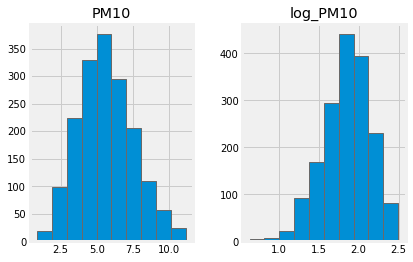

In [21]:

dist_df = pd.DataFrame({'PM10' : df2['PM10'].values, 'log_PM10' : dataset[:,0]})


plt.figure(figsize=(12,5))
dist_df.hist();

In [22]:

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1301 434


In [23]:

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (1299, 1)
Shape of trainY : (1299,)
Shape of testX : (432, 1)
Shape of testY : (432,)


In [24]:

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (1299, 1, 1)
Shape of testX : (432, 1, 1)


In [25]:

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1500, batch_size=32, verbose=2)

Epoch 1/1500
 - 1s - loss: 2.9287
Epoch 2/1500
 - 0s - loss: 2.5191
Epoch 3/1500
 - 0s - loss: 2.1146
Epoch 4/1500
 - 0s - loss: 1.7144
Epoch 5/1500
 - 0s - loss: 1.3390
Epoch 6/1500
 - 0s - loss: 1.0101
Epoch 7/1500
 - 0s - loss: 0.7413
Epoch 8/1500
 - 0s - loss: 0.5337
Epoch 9/1500
 - 0s - loss: 0.3814
Epoch 10/1500
 - 0s - loss: 0.2754
Epoch 11/1500
 - 0s - loss: 0.2044
Epoch 12/1500
 - 0s - loss: 0.1598
Epoch 13/1500
 - 0s - loss: 0.1326
Epoch 14/1500
 - 0s - loss: 0.1170
Epoch 15/1500
 - 0s - loss: 0.1085
Epoch 16/1500
 - 0s - loss: 0.1041
Epoch 17/1500
 - 0s - loss: 0.1018
Epoch 18/1500
 - 0s - loss: 0.1008
Epoch 19/1500
 - 0s - loss: 0.1003
Epoch 20/1500
 - 0s - loss: 0.1000
Epoch 21/1500
 - 0s - loss: 0.0998
Epoch 22/1500
 - 0s - loss: 0.0997
Epoch 23/1500
 - 0s - loss: 0.0996
Epoch 24/1500
 - 0s - loss: 0.0995
Epoch 25/1500
 - 0s - loss: 0.0995
Epoch 26/1500
 - 0s - loss: 0.0994
Epoch 27/1500
 - 0s - loss: 0.0993
Epoch 28/1500
 - 0s - loss: 0.0992
Epoch 29/1500
 - 0s - loss: 0

Epoch 232/1500
 - 0s - loss: 0.0909
Epoch 233/1500
 - 0s - loss: 0.0909
Epoch 234/1500
 - 0s - loss: 0.0910
Epoch 235/1500
 - 0s - loss: 0.0909
Epoch 236/1500
 - 0s - loss: 0.0909
Epoch 237/1500
 - 0s - loss: 0.0909
Epoch 238/1500
 - 0s - loss: 0.0911
Epoch 239/1500
 - 0s - loss: 0.0909
Epoch 240/1500
 - 0s - loss: 0.0910
Epoch 241/1500
 - 0s - loss: 0.0910
Epoch 242/1500
 - 0s - loss: 0.0909
Epoch 243/1500
 - 0s - loss: 0.0909
Epoch 244/1500
 - 0s - loss: 0.0911
Epoch 245/1500
 - 0s - loss: 0.0909
Epoch 246/1500
 - 0s - loss: 0.0912
Epoch 247/1500
 - 0s - loss: 0.0910
Epoch 248/1500
 - 0s - loss: 0.0909
Epoch 249/1500
 - 0s - loss: 0.0909
Epoch 250/1500
 - 0s - loss: 0.0909
Epoch 251/1500
 - 0s - loss: 0.0910
Epoch 252/1500
 - 0s - loss: 0.0910
Epoch 253/1500
 - 0s - loss: 0.0909
Epoch 254/1500
 - 0s - loss: 0.0909
Epoch 255/1500
 - 0s - loss: 0.0909
Epoch 256/1500
 - 0s - loss: 0.0909
Epoch 257/1500
 - 0s - loss: 0.0909
Epoch 258/1500
 - 0s - loss: 0.0911
Epoch 259/1500
 - 0s - loss:

Epoch 460/1500
 - 0s - loss: 0.0911
Epoch 461/1500
 - 0s - loss: 0.0909
Epoch 462/1500
 - 0s - loss: 0.0909
Epoch 463/1500
 - 0s - loss: 0.0910
Epoch 464/1500
 - 0s - loss: 0.0909
Epoch 465/1500
 - 0s - loss: 0.0910
Epoch 466/1500
 - 0s - loss: 0.0910
Epoch 467/1500
 - 0s - loss: 0.0911
Epoch 468/1500
 - 0s - loss: 0.0911
Epoch 469/1500
 - 0s - loss: 0.0909
Epoch 470/1500
 - 0s - loss: 0.0910
Epoch 471/1500
 - 0s - loss: 0.0909
Epoch 472/1500
 - 0s - loss: 0.0910
Epoch 473/1500
 - 0s - loss: 0.0910
Epoch 474/1500
 - 0s - loss: 0.0908
Epoch 475/1500
 - 0s - loss: 0.0910
Epoch 476/1500
 - 0s - loss: 0.0909
Epoch 477/1500
 - 0s - loss: 0.0909
Epoch 478/1500
 - 0s - loss: 0.0909
Epoch 479/1500
 - 0s - loss: 0.0910
Epoch 480/1500
 - 0s - loss: 0.0909
Epoch 481/1500
 - 0s - loss: 0.0909
Epoch 482/1500
 - 0s - loss: 0.0909
Epoch 483/1500
 - 0s - loss: 0.0909
Epoch 484/1500
 - 0s - loss: 0.0910
Epoch 485/1500
 - 0s - loss: 0.0911
Epoch 486/1500
 - 0s - loss: 0.0909
Epoch 487/1500
 - 0s - loss:

Epoch 688/1500
 - 0s - loss: 0.0908
Epoch 689/1500
 - 0s - loss: 0.0909
Epoch 690/1500
 - 0s - loss: 0.0910
Epoch 691/1500
 - 0s - loss: 0.0909
Epoch 692/1500
 - 0s - loss: 0.0909
Epoch 693/1500
 - 0s - loss: 0.0909
Epoch 694/1500
 - 0s - loss: 0.0909
Epoch 695/1500
 - 0s - loss: 0.0908
Epoch 696/1500
 - 0s - loss: 0.0908
Epoch 697/1500
 - 0s - loss: 0.0910
Epoch 698/1500
 - 0s - loss: 0.0909
Epoch 699/1500
 - 0s - loss: 0.0911
Epoch 700/1500
 - 0s - loss: 0.0909
Epoch 701/1500
 - 0s - loss: 0.0909
Epoch 702/1500
 - 0s - loss: 0.0910
Epoch 703/1500
 - 0s - loss: 0.0910
Epoch 704/1500
 - 0s - loss: 0.0909
Epoch 705/1500
 - 0s - loss: 0.0910
Epoch 706/1500
 - 0s - loss: 0.0909
Epoch 707/1500
 - 0s - loss: 0.0909
Epoch 708/1500
 - 0s - loss: 0.0909
Epoch 709/1500
 - 0s - loss: 0.0910
Epoch 710/1500
 - 0s - loss: 0.0909
Epoch 711/1500
 - 0s - loss: 0.0908
Epoch 712/1500
 - 0s - loss: 0.0909
Epoch 713/1500
 - 0s - loss: 0.0910
Epoch 714/1500
 - 0s - loss: 0.0909
Epoch 715/1500
 - 0s - loss:

Epoch 916/1500
 - 0s - loss: 0.0910
Epoch 917/1500
 - 0s - loss: 0.0908
Epoch 918/1500
 - 0s - loss: 0.0909
Epoch 919/1500
 - 0s - loss: 0.0909
Epoch 920/1500
 - 0s - loss: 0.0909
Epoch 921/1500
 - 0s - loss: 0.0909
Epoch 922/1500
 - 0s - loss: 0.0910
Epoch 923/1500
 - 0s - loss: 0.0909
Epoch 924/1500
 - 0s - loss: 0.0909
Epoch 925/1500
 - 0s - loss: 0.0910
Epoch 926/1500
 - 0s - loss: 0.0910
Epoch 927/1500
 - 0s - loss: 0.0909
Epoch 928/1500
 - 0s - loss: 0.0909
Epoch 929/1500
 - 0s - loss: 0.0908
Epoch 930/1500
 - 0s - loss: 0.0909
Epoch 931/1500
 - 0s - loss: 0.0911
Epoch 932/1500
 - 0s - loss: 0.0909
Epoch 933/1500
 - 0s - loss: 0.0909
Epoch 934/1500
 - 0s - loss: 0.0908
Epoch 935/1500
 - 0s - loss: 0.0911
Epoch 936/1500
 - 0s - loss: 0.0912
Epoch 937/1500
 - 0s - loss: 0.0910
Epoch 938/1500
 - 0s - loss: 0.0909
Epoch 939/1500
 - 0s - loss: 0.0909
Epoch 940/1500
 - 0s - loss: 0.0909
Epoch 941/1500
 - 0s - loss: 0.0910
Epoch 942/1500
 - 0s - loss: 0.0910
Epoch 943/1500
 - 0s - loss:

Epoch 1140/1500
 - 0s - loss: 0.0910
Epoch 1141/1500
 - 0s - loss: 0.0909
Epoch 1142/1500
 - 0s - loss: 0.0908
Epoch 1143/1500
 - 0s - loss: 0.0908
Epoch 1144/1500
 - 0s - loss: 0.0910
Epoch 1145/1500
 - 0s - loss: 0.0908
Epoch 1146/1500
 - 0s - loss: 0.0909
Epoch 1147/1500
 - 0s - loss: 0.0909
Epoch 1148/1500
 - 0s - loss: 0.0908
Epoch 1149/1500
 - 0s - loss: 0.0909
Epoch 1150/1500
 - 0s - loss: 0.0911
Epoch 1151/1500
 - 0s - loss: 0.0909
Epoch 1152/1500
 - 0s - loss: 0.0909
Epoch 1153/1500
 - 0s - loss: 0.0909
Epoch 1154/1500
 - 0s - loss: 0.0909
Epoch 1155/1500
 - 0s - loss: 0.0909
Epoch 1156/1500
 - 0s - loss: 0.0909
Epoch 1157/1500
 - 0s - loss: 0.0909
Epoch 1158/1500
 - 0s - loss: 0.0909
Epoch 1159/1500
 - 0s - loss: 0.0912
Epoch 1160/1500
 - 0s - loss: 0.0909
Epoch 1161/1500
 - 0s - loss: 0.0909
Epoch 1162/1500
 - 0s - loss: 0.0911
Epoch 1163/1500
 - 0s - loss: 0.0909
Epoch 1164/1500
 - 0s - loss: 0.0909
Epoch 1165/1500
 - 0s - loss: 0.0909
Epoch 1166/1500
 - 0s - loss: 0.0909
E

Epoch 1362/1500
 - 0s - loss: 0.0909
Epoch 1363/1500
 - 0s - loss: 0.0908
Epoch 1364/1500
 - 0s - loss: 0.0910
Epoch 1365/1500
 - 0s - loss: 0.0909
Epoch 1366/1500
 - 0s - loss: 0.0909
Epoch 1367/1500
 - 0s - loss: 0.0909
Epoch 1368/1500
 - 0s - loss: 0.0909
Epoch 1369/1500
 - 0s - loss: 0.0909
Epoch 1370/1500
 - 0s - loss: 0.0909
Epoch 1371/1500
 - 0s - loss: 0.0908
Epoch 1372/1500
 - 0s - loss: 0.0909
Epoch 1373/1500
 - 0s - loss: 0.0908
Epoch 1374/1500
 - 0s - loss: 0.0908
Epoch 1375/1500
 - 0s - loss: 0.0909
Epoch 1376/1500
 - 0s - loss: 0.0909
Epoch 1377/1500
 - 0s - loss: 0.0908
Epoch 1378/1500
 - 0s - loss: 0.0911
Epoch 1379/1500
 - 0s - loss: 0.0909
Epoch 1380/1500
 - 0s - loss: 0.0912
Epoch 1381/1500
 - 0s - loss: 0.0909
Epoch 1382/1500
 - 0s - loss: 0.0909
Epoch 1383/1500
 - 0s - loss: 0.0908
Epoch 1384/1500
 - 0s - loss: 0.0910
Epoch 1385/1500
 - 0s - loss: 0.0909
Epoch 1386/1500
 - 0s - loss: 0.0908
Epoch 1387/1500
 - 0s - loss: 0.0909
Epoch 1388/1500
 - 0s - loss: 0.0908
E

In [26]:

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)


trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.92 RMSE
Test Score: 1.76 RMSE


In [27]:
test_series = pd.Series(testY)

if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is NOT GOOD enough ]

RMSE of test prediction > Standard deviation of test dataset
1.76 > 1.75


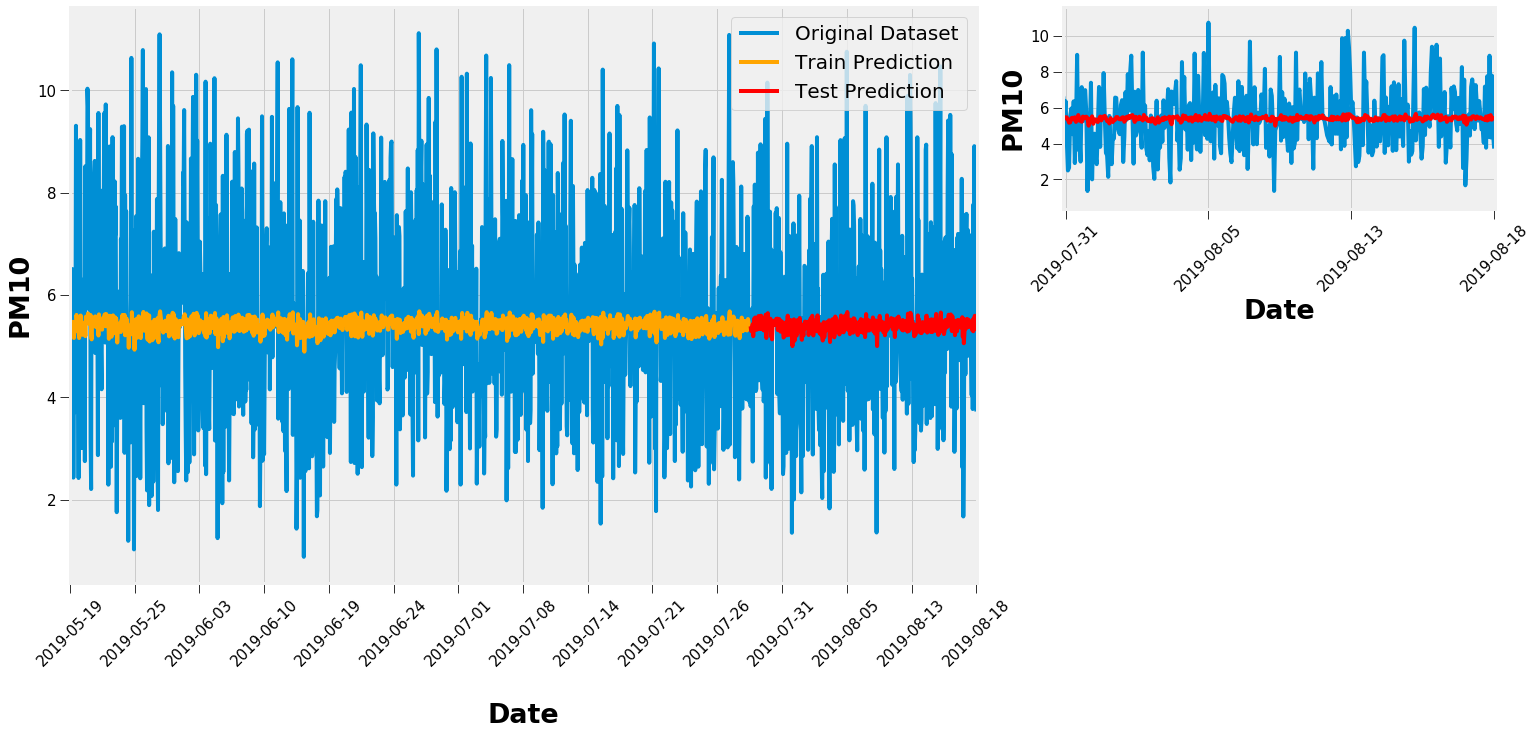

In [28]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(df2.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

In [29]:

dataset = np.log1p(df2[['HUM']].values)
dataset.shape

(1735, 1)

<Figure size 864x360 with 0 Axes>

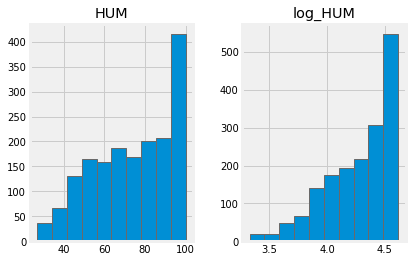

In [30]:

dist_df = pd.DataFrame({'HUM' : df2['HUM'].values, 'log_HUM' : dataset[:,0]})


plt.figure(figsize=(12,5))
dist_df.hist();

In [31]:

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1301 434


In [32]:

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (1299, 1)
Shape of trainY : (1299,)
Shape of testX : (432, 1)
Shape of testY : (432,)
